<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/26_Lite_%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Lite

Работа осуществляется с базой акции лукойла.

1. Обучите простую полносвязную сеть для прогнозирования временного ряда. Используйте только столбец close и визуализируйте результат.

2. Обучите такую же архитектуру сети на прогнозирование на 10 шагов вперёд прямым способом и визуализируйте результат.

3. Постройте графики сравнения предсказания с оригинальным сигналом по всем 10 шагам предсказания (10 графиков на разных отдельных осях).

4. Сделайте те же задания с другой сетью, которая будет использовать Conv1D или LSTM слой


In [1]:
#Загружаем библиотеки
import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианта моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов

# Рисовать графики сразу же
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Загрузка и обработка данных 

In [3]:
base_data16 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Базы/16_17.csv', sep=';')
base_data18 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Базы/18_19.csv', sep=';')
data16_17 = base_data16.iloc[:,2:]
data18_19 = base_data18.iloc[:,2:]

In [4]:
data16_17.shape[0]

263925

In [5]:
# Объединяем базы из двух файлов
data = data16_17.copy()                 # Создаем копию первой базы
data = pd.concat([data16_17,data18_19]) # Присоединяем к ней вторую базу
data = np.array(data)                   # Превращаем в numpy массив

In [6]:
# Сравниваем размеры
print(len(data16_17)) # Выводим размер первой базы
print(len(data18_19)) # Выводим размер второй базы
print(len(data))      # Выводим размер суммарной базы

263925
217947
481872


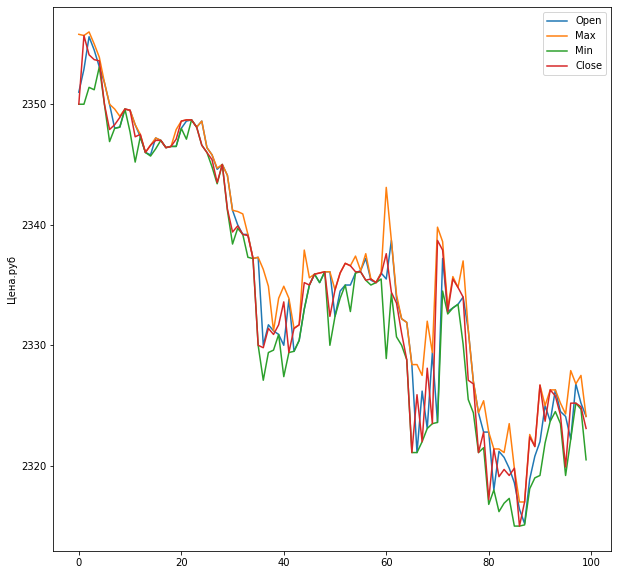

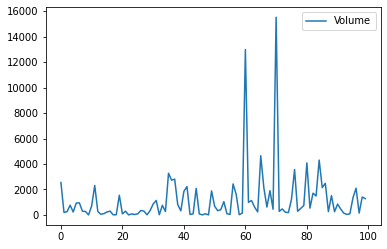

In [7]:
plt.figure(figsize=(10,10))
#Отображаем исходные от точки start и длинной stop
start = 0            #С какой точки начинаем
#stop = data.shape[0] #Сколько точек отрисуем
stop = 100 #Сколько точек отрисуем

#Заполняем текстовые названия каналов данных
chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']

#Рисуем все графики данных
#Четыре основных канала - open, max, min, close
for i in range(4):
  #Отрисовываем часть данных
  #От начальной точки, до начальной точки + размер шага отрисовки
  plt.plot(data[start:start+stop,i], 
          label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

#Канал volume
plt.plot(data[start:start+stop,4], label="Volume")
plt.legend()
plt.show()

In [8]:
#Формируем параметры загрузки данных

xLen = 300                      #Анализируем по 300 прошедшим точкам 
valLen = 30000                  #Используем 30.000 записей для проверки

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain,xTest = data[:trainLen], data[trainLen+xLen+2:]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape,т. к. у нас только один столбец по одному значению
yTrain,yTest = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen+xLen+2:,3],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, stride=1, sampling_rate=1, #Для каждой точки (из промежутка длины xLen)
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, stride=1,
                               batch_size=20)

In [9]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(20, 300, 5) (20, 1)


In [10]:
# Функция рассчитывает результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходный масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка, с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расчёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смещении на i шагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличиваем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смещении на i рагов обратно

      # Постепенно увеличиваем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [11]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

# Простая полносвязная сеть для прогнозирования на 1 шаг

Epoch 1/10
22579/22579 [==============================] - 72s 3ms/step - loss: 0.0057 - val_loss: 2.3404e-05
Epoch 2/10
22579/22579 [==============================] - 70s 3ms/step - loss: 2.8073e-04 - val_loss: 1.5952e-05
Epoch 3/10
22579/22579 [==============================] - 69s 3ms/step - loss: 1.2098e-04 - val_loss: 1.8392e-05
Epoch 4/10
22579/22579 [==============================] - 69s 3ms/step - loss: 9.4404e-05 - val_loss: 1.2516e-05
Epoch 5/10
22579/22579 [==============================] - 71s 3ms/step - loss: 6.5911e-05 - val_loss: 1.6016e-05
Epoch 6/10
22579/22579 [==============================] - 69s 3ms/step - loss: 4.3480e-05 - val_loss: 7.0773e-06
Epoch 7/10
22579/22579 [==============================] - 69s 3ms/step - loss: 3.7722e-05 - val_loss: 1.8104e-05
Epoch 8/10
22579/22579 [==============================] - 69s 3ms/step - loss: 2.3647e-05 - val_loss: 4.3010e-05
Epoch 9/10
22579/22579 [==============================] - 69s 3ms/step - loss: 2.4999e-05 - val_loss

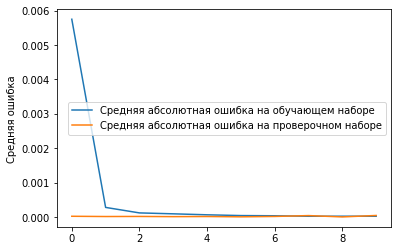

In [12]:
#Создаём нейронку
modelD = Sequential()
modelD.add(Dense(150,input_shape = (xLen,5), activation="linear" )) # 5 - количество каналов
modelD.add(Flatten())
modelD.add(Dense(1, activation="linear"))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(learning_rate=1e-4))

#Запускаем обучение
history = modelD.fit(
                    trainDataGen, 
                    epochs=10, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

#Выводим графики
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

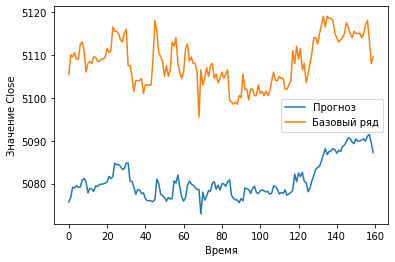

In [13]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)


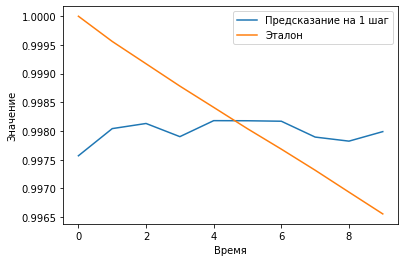

In [14]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 10 шагов
showCorr([0], 10, predVal, yValUnscaled)

#Загрузка и обработка данных по 10 значений в Y

In [15]:
base_data16_10 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Базы/16_17.csv', sep=';')
base_data18_10 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Базы/18_19.csv', sep=';')
data16_17_10 = base_data16.iloc[:,2:]
data18_19_10 = base_data18.iloc[:,2:]

In [16]:
print(data16_17_10.shape[0])
print('data16_17_10', data16_17_10[:10], sep='\n')
print('data18_19_10', data18_19_10[:10], sep='\n')

263925
data16_17_10
     OPEN     MAX     MIN   CLOSE  VOLUME
0  2351.0  2355.8  2350.0  2350.0    2547
1  2352.9  2355.7  2350.0  2355.7     195
2  2355.6  2356.0  2351.4  2354.1     257
3  2354.5  2355.0  2351.2  2353.7     763
4  2353.1  2353.9  2353.1  2353.6     231
5  2351.8  2351.8  2350.0  2350.0     934
6  2350.0  2350.0  2346.9  2347.9     948
7  2348.0  2349.6  2348.0  2348.3     293
8  2348.1  2349.0  2348.1  2348.9     269
9  2349.6  2349.6  2349.6  2349.6       1
data18_19_10
     OPEN     MAX     MIN   CLOSE  VOLUME
0  3341.0  3356.0  3340.0  3355.0    6088
1  3355.0  3359.0  3353.0  3353.0    1624
2  3351.5  3357.5  3351.5  3357.5     722
3  3354.5  3360.0  3354.5  3358.0    3034
4  3358.0  3360.0  3351.5  3360.0    1427
5  3360.0  3363.5  3346.5  3353.0    3390
6  3350.5  3351.5  3348.5  3350.0     412
7  3350.5  3353.0  3349.0  3353.0     156
8  3354.0  3354.5  3352.5  3354.5     123
9  3352.5  3352.5  3352.5  3352.5       1


In [17]:
# Объединяем базы из двух файлов
data_10 = data16_17_10.copy()                 # Создаем копию первой базы
data_10 = pd.concat([data16_17_10,data18_19_10]) # Присоединяем к ней вторую базу
data_10 = np.array(data_10)                   # Превращаем в numpy массив
data_10[:10]

array([[2.3510e+03, 2.3558e+03, 2.3500e+03, 2.3500e+03, 2.5470e+03],
       [2.3529e+03, 2.3557e+03, 2.3500e+03, 2.3557e+03, 1.9500e+02],
       [2.3556e+03, 2.3560e+03, 2.3514e+03, 2.3541e+03, 2.5700e+02],
       [2.3545e+03, 2.3550e+03, 2.3512e+03, 2.3537e+03, 7.6300e+02],
       [2.3531e+03, 2.3539e+03, 2.3531e+03, 2.3536e+03, 2.3100e+02],
       [2.3518e+03, 2.3518e+03, 2.3500e+03, 2.3500e+03, 9.3400e+02],
       [2.3500e+03, 2.3500e+03, 2.3469e+03, 2.3479e+03, 9.4800e+02],
       [2.3480e+03, 2.3496e+03, 2.3480e+03, 2.3483e+03, 2.9300e+02],
       [2.3481e+03, 2.3490e+03, 2.3481e+03, 2.3489e+03, 2.6900e+02],
       [2.3496e+03, 2.3496e+03, 2.3496e+03, 2.3496e+03, 1.0000e+00]])

In [18]:
# Сравниваем размеры
print(len(data16_17_10)) # Выводим размер первой базы
print(len(data18_19_10)) # Выводим размер второй базы
print(len(data_10))      # Выводим размер суммарной базы

263925
217947
481872


In [19]:
#data_10 - Numpy array
#Normalization = 0 - нормальное распределение, 1 - к отрезку [0;1], -1 - не нормализовывать
def DataNormalization(data_10, Channels, Normalization):
  #Выбираем тип нормализации x
  #0 - нормальное распределение
  #1 - нормирование до отрезка 0-1
  if (Normalization == 0):
    scaler = StandardScaler()
  if (Normalization == 1):
    scaler = MinMaxScaler()
  
  #Берём только те каналы, которые указаны в аргументе функции
  resData = data_10[:,Channels]

  if (len(resData.shape) == 1): #Если размерность входного массива - одномерный вектор, 
    print("Add one dimension")
    resData = np.expand_dims(resData, axis=1) #то добавляем размерность
 
  if (Normalization == -1):
    scaler = np.zeros(resData.shape[0])
    return (resData, scaler)
 
  #Обучаем нормировщик
  scaler.fit(resData)
  #Нормируем данные
  resData = scaler.transform(resData)
  return (resData, scaler)

Теперь сама функция по «раскусыванию» временного ряда для подготовки к передаче на сеть:

In [20]:
# data_10 - данные
#xLen - размер "окна", по которому предсказываем
#xChannels - лист, номера каналов, по которым делаем анализ
#yChannels - лист, номера каналов, которые предсказываем
#stepsForward - на сколько шагов предсказываем в будущее 
#               если 1 - то на 1 шаг, можно использовать только при одном канале, указанном в yChannels
#xNormalization - нормализация входных каналов, 0 - нормальное распределение, 1 - к отрезку [0;1], -1 - не нормализовывать
#yNormalization - нормализация прогнозируемых каналов, 0 - нормальное распределение, 1 - к отрезку [0;1], -1 - не нормализовывать
#returnFlatten - True - если на выходе получить одномерный вектор для Dense сетей
#valLen - сколько примеров брать для проверочной выборки (количество для обучающей посчитается автоматиески)
#convertToDerivative - bool, преобразовывали ли входные сигналы в производную
def getTrainSeq(data_10, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative):
  #Если указано превращение данных в производную
  #То вычитаем поточечно из текущей точки предыдущую
  if (convertToDerivative):
    data_10 = np.array([(d[1:]-d[:-1]) for d in data.T]).copy().T
  else:
    if isinstance(data_10,(pd.core.series.Series, pd.core.frame.DataFrame)): #Проверяем, если на входе Pandas - то, берем values, для получения numpy Array
      print("Convert Pandas.Series to Numpy array")
      data_10 = data.values

  #Нормализуем данные
  (xData, xScaler) = DataNormalization(data_10, xChannels, xNormalization)
  (yData, yScaler) = DataNormalization(data_10, yChannels, yNormalization)

  valLen = valLen + xLen - 1 + stepsForward #Вычисляем сколько данных с конца нужно взять, чтобы размерность xVal/yVal была valLen

  #Разбивка входного ряда до обработки
  xTrain = xData[:xData.shape[0]-valLen] 
  yTrain = yData[:yData.shape[0]-valLen] 

  xVal = xData[xData.shape[0]-valLen:] 
  yVal = yData[yData.shape[0]-valLen:] 

  xTrain = np.array([xTrain[i:i + xLen, xChannels] for i in range(xTrain.shape[0] - xLen + 1 - stepsForward)])
  yTrain = np.array([yTrain[i:i + stepsForward, yChannels] for i in range(xLen, yTrain.shape[0] + 1 - stepsForward)])

  xVal = np.array([xVal[i:i + xLen, xChannels] for i in range(xVal.shape[0] - xLen + 1 - stepsForward)])
  yVal = np.array([yVal[i:i + stepsForward, yChannels] for i in range(xLen, yVal.shape[0] + 1 - stepsForward)])

  #Если в функцию передали вернуть flatten сигнал (для Dense сети), то xTrain и xVal превращаем в flatten
  if (returnFlatten == True):
    xTrain = np.array([x.flatten() for x in xTrain])
    xVal = np.array([x.flatten() for x in xVal])

  return (xTrain, yTrain), (xVal, yVal), (xScaler, yScaler)

Нейронная сеть будет пытаться найти закономерности между каждой серией X длиной xLen и Y длиной stepsForward.

In [21]:
xLen = 300 #Анализируем по 300 прошедшим точкам 
stepsForward = 10            #Тренируем сеть для предсказания на 10 шагов вперед
xChannels = range(data_10.shape[1]) #Используем все входные каналы
yChannels = 0               #Предказываем только open канал
xNormalization = 0          #Нормируем входные каналы стандартным распределением
yNormalization = 0          #Нормируем выходные каналы стандартным распределением
valLen = 30000              #Используем 30.000 записей для проверки0
returnFlatten = False       #Если True, то вернуть одномерные векторы, если False, то двумерные
convertToDerivative = False #Не True, то превращать в производную

(xTrain, yTrain), (xVal, yVal), (xScaler, yScaler) = getTrainSeq(data_10, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative)

#Выводим размеры данных для проверки
print("xTrain.shape:", xTrain.shape)
print("yTrain.shape:", yTrain.shape)
print("xVal.shape:", xVal.shape)
print("yVal.shape:", yVal.shape)

Add one dimension
xTrain.shape: (451254, 300, 5)
yTrain.shape: (451254, 10)
xVal.shape: (30000, 300, 5)
yVal.shape: (30000, 10)


# Простая полносвязная сеть для прогнозирования временного ряда по 10 значений в Y

Epoch 1/10
14102/14102 [==============================] - 44s 3ms/step - loss: 0.0185 - val_loss: 9.9991e-04
Epoch 2/10
14102/14102 [==============================] - 42s 3ms/step - loss: 4.5390e-04 - val_loss: 1.9329e-04
Epoch 3/10
14102/14102 [==============================] - 42s 3ms/step - loss: 1.0248e-04 - val_loss: 8.6255e-05
Epoch 4/10
14102/14102 [==============================] - 42s 3ms/step - loss: 7.6023e-05 - val_loss: 7.8814e-05
Epoch 5/10
14102/14102 [==============================] - 42s 3ms/step - loss: 6.8775e-05 - val_loss: 9.2124e-05
Epoch 6/10
14102/14102 [==============================] - 42s 3ms/step - loss: 7.5818e-05 - val_loss: 1.0273e-04
Epoch 7/10
14102/14102 [==============================] - 42s 3ms/step - loss: 8.8223e-05 - val_loss: 9.2533e-05
Epoch 8/10
14102/14102 [==============================] - 43s 3ms/step - loss: 6.5312e-05 - val_loss: 6.0747e-05
Epoch 9/10
14102/14102 [==============================] - 42s 3ms/step - loss: 9.4107e-05 - val_loss

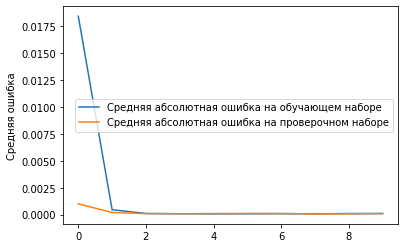

In [22]:
#Создаём такую же нейронку под прогноз на 10 шагов вперед
modelD_10 = Sequential()
modelD_10.add(Dense(150,input_shape = (xLen,5), activation="linear" )) # 5 - количество каналов
modelD_10.add(Flatten())
modelD_10.add(Dense(10, activation="linear"))

#Компилируем
modelD_10.compile(loss="mse", optimizer=Adam(learning_rate=1e-4))

#Запускаем обучение
history = modelD_10.fit(xTrain, yTrain,
                        epochs=10, 
                        verbose=1, 
                        validation_data = (xVal, yVal))

#Выводим графики
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [29]:
#Прогнозируем данные текущей сетью
currModel = modelD_10 #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler) #Прогнозируем данные



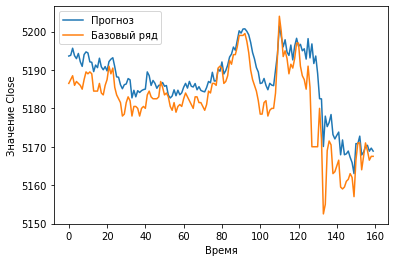

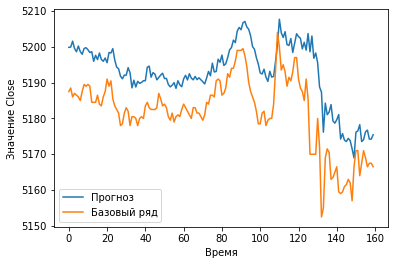

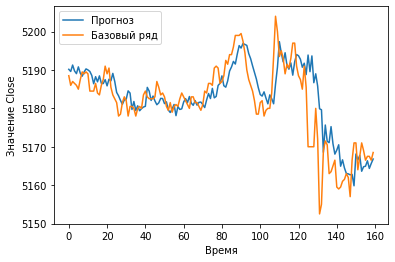

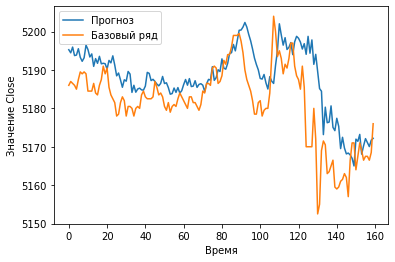

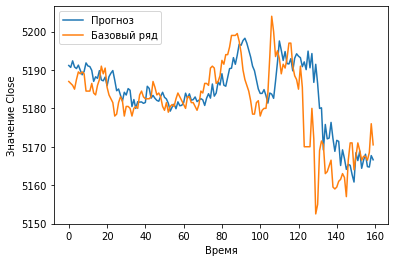

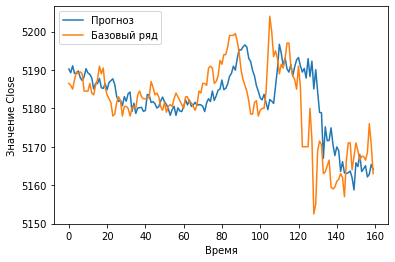

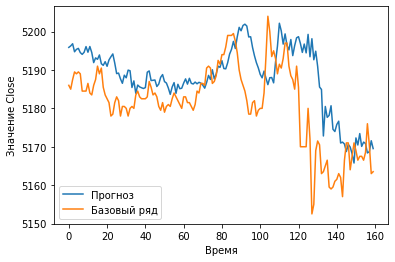

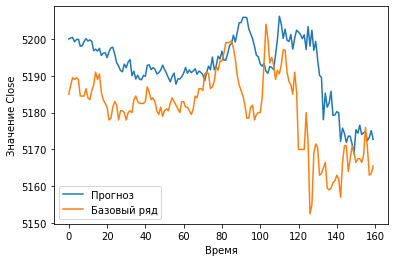

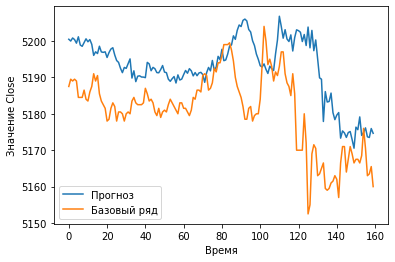

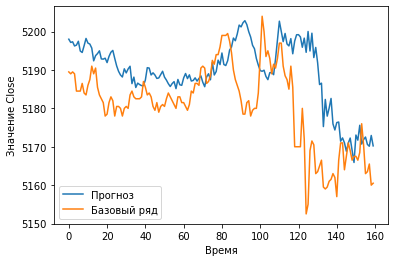

In [30]:
#Отображаем графики
for i in range(10):
    showPredict(0, 160, i, predVal, yValUnscaled)

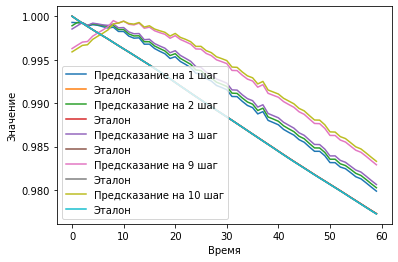

In [31]:
#Отображаем корреляцию
#Используем выходной канал - только close
#Проверяем корреляцию на глубину 60 шагов
showCorr([0, 1, 2, 8, 9], 60, predVal, yValUnscaled)

# Сonv1D - прогноз на 1 шаг

In [ ]:
modelC = Sequential()

modelC.add(Conv1D(64, 5, input_shape = (xLen,5), activation="relu"))
modelC.add(Conv1D(64, 5, activation="relu"))
modelC.add(MaxPooling1D())
modelC.add(Flatten())
modelC.add(Dense(100, activation="relu"))
modelC.add(Dense(1, activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

modelC.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 296, 64)           1664      
                                                                 
 conv1d_3 (Conv1D)           (None, 292, 64)           20544     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 146, 64)          0         
 )                                                               
                                                                 
 flatten_3 (Flatten)         (None, 9344)              0         
                                                                 
 dense_6 (Dense)             (None, 100)               934500    
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = modelC.fit(trainDataGen,
                    epochs=50, 
                    verbose=1,
                    validation_data=testDataGen)

Epoch 1/50
22579/22579 [==============================] - 80s 3ms/step - loss: 1.9883e-04 - val_loss: 2.1839e-04
Epoch 2/50
22579/22579 [==============================] - 72s 3ms/step - loss: 6.4535e-05 - val_loss: 3.1285e-04
Epoch 3/50
22579/22579 [==============================] - 72s 3ms/step - loss: 4.6540e-05 - val_loss: 2.1696e-05
Epoch 4/50
22579/22579 [==============================] - 71s 3ms/step - loss: 4.0903e-05 - val_loss: 4.8760e-05
Epoch 5/50
22579/22579 [==============================] - 71s 3ms/step - loss: 3.6402e-05 - val_loss: 8.5904e-05
Epoch 6/50
22579/22579 [==============================] - 71s 3ms/step - loss: 2.9758e-05 - val_loss: 1.7334e-05
Epoch 7/50
22579/22579 [==============================] - 71s 3ms/step - loss: 2.7383e-05 - val_loss: 1.1305e-05
Epoch 8/50
22579/22579 [==============================] - 71s 3ms/step - loss: 2.8282e-05 - val_loss: 2.7786e-05
Epoch 9/50
22579/22579 [==============================] - 70s 3ms/step - loss: 2.6316e-05 - val_

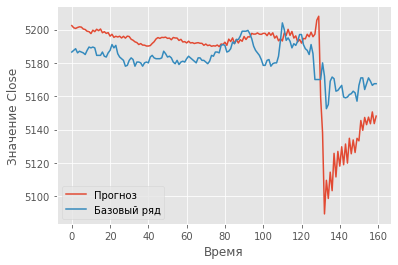

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)


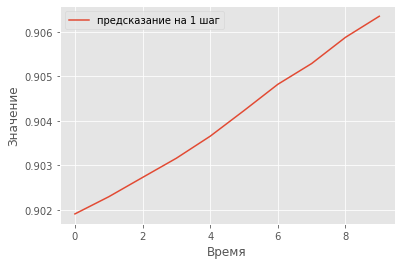

In [ ]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 10 шагов
showCorr([0], 10, predVal, yValUnscaled)

# Сonv1D - прогноз на 10 шагов

In [33]:
modelC_10 = Sequential()

modelC_10.add(Conv1D(64, 5, input_shape = (xLen,5), activation="relu"))
modelC_10.add(Conv1D(64, 5, activation="relu"))
modelC_10.add(MaxPooling1D())
modelC_10.add(Flatten())
modelC_10.add(Dense(100, activation="relu"))
modelC_10.add(Dense(10, activation="linear"))

modelC_10.compile(loss="mse", optimizer=Adam(lr=1e-4))

modelC_10.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 296, 64)           1664      
                                                                 
 conv1d_3 (Conv1D)           (None, 292, 64)           20544     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 146, 64)          0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 9344)              0         
                                                                 
 dense_6 (Dense)             (None, 100)               934500    
                                                                 
 dense_7 (Dense)             (None, 10)                1010      
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
14102/14102 [==============================] - 64s 4ms/step - loss: 0.0013 - val_loss: 3.9013e-04
Epoch 2/10
14102/14102 [==============================] - 56s 4ms/step - loss: 1.5590e-04 - val_loss: 3.9225e-04
Epoch 3/10
14102/14102 [==============================] - 56s 4ms/step - loss: 1.1251e-04 - val_loss: 1.6083e-04
Epoch 4/10
14102/14102 [==============================] - 56s 4ms/step - loss: 1.0729e-04 - val_loss: 3.0210e-04
Epoch 5/10
14102/14102 [==============================] - 57s 4ms/step - loss: 8.6217e-05 - val_loss: 1.4358e-04
Epoch 6/10
14102/14102 [==============================] - 56s 4ms/step - loss: 7.5584e-05 - val_loss: 1.5790e-04
Epoch 7/10
14102/14102 [==============================] - 56s 4ms/step - loss: 7.8219e-05 - val_loss: 1.7817e-04
Epoch 8/10
14102/14102 [==============================] - 56s 4ms/step - loss: 7.3743e-05 - val_loss: 4.9898e-04
Epoch 9/10
14102/14102 [==============================] - 56s 4ms/step - loss: 7.1641e-05 - val_loss

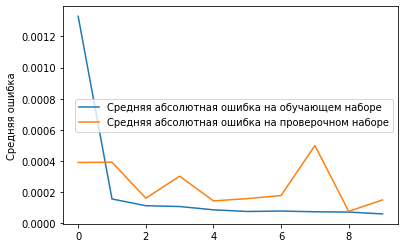

In [34]:
history = modelC_10.fit(xTrain, yTrain,
                        epochs=10, 
                        verbose=1, 
                        validation_data = (xVal, yVal))

#Выводим графики
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [37]:
#Прогнозируем данные текущей сетью
currModel = modelC_10 #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler) #Прогнозируем данные



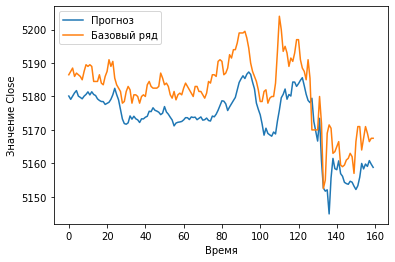

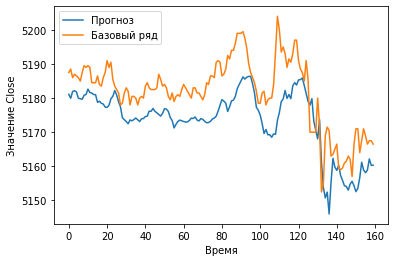

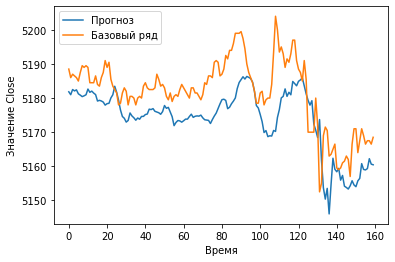

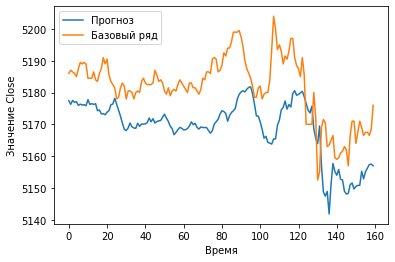

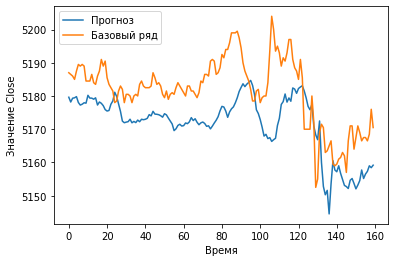

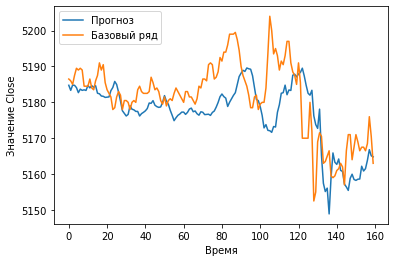

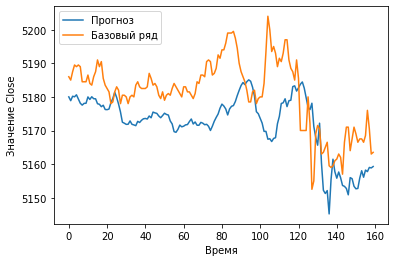

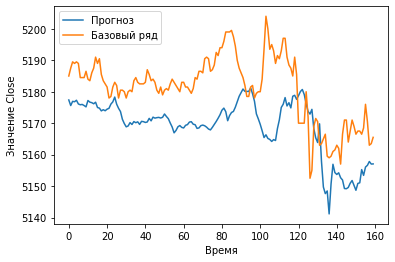

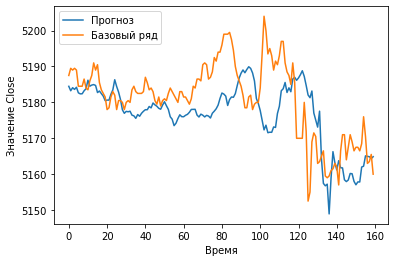

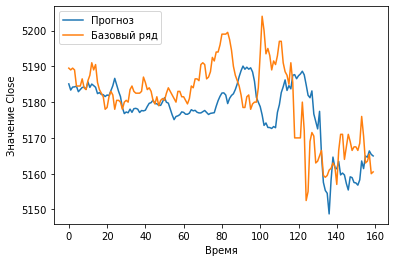

In [38]:
#Отображаем графики
for i in range(10):
    showPredict(0, 160, i, predVal, yValUnscaled)

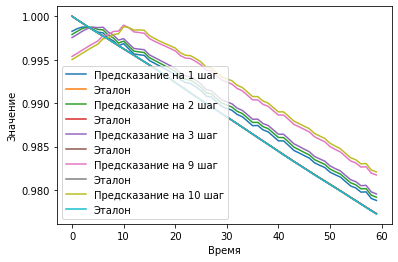

In [39]:
#Отображаем корреляцию
#Используем выходной канал - только close
#Проверяем корреляцию на глубину 60 шагов
showCorr([0, 1, 2, 8, 9], 60, predVal, yValUnscaled)

# Еще вариант формирования выборки на 10 шагов вперед

In [40]:
base_data16 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Базы/16_17.csv', sep=';')
base_data18 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Базы/18_19.csv', sep=';')
data16_17 = base_data16.iloc[:,2:]
data18_19 = base_data18.iloc[:,2:]

In [41]:
data16_17.shape[0]

263925

In [42]:
# Объединяем базы из двух файлов
data_10v1 = data16_17.copy()                 # Создаем копию первой базы
data_10v1 = pd.concat([data16_17,data18_19]) # Присоединяем к ней вторую базу
data_10v1 = np.array(data)                   # Превращаем в numpy массив

In [43]:
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смещении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смещении на i шагов обратно

      # Постепенно увеличиваем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [44]:
#Формируем параметры загрузки данных
xLen = 300                       #Анализируем по 300 прошедшим точкам 
valLen = 30000                   #Используем 30000 записей для проверки
stepsForward = 10
trainLen = data_10v1.shape[0]-valLen #Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain_10v1,xTest_10v1 = data_10v1[:trainLen-stepsForward], data_10v1[trainLen+xLen+2:-stepsForward+1]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = StandardScaler()
xScaler.fit(xTrain_10v1)
xTrain_10v1 = xScaler.transform(xTrain_10v1)
xTest_10v1 = xScaler.transform(xTest_10v1)

#Для подготовки yTrain на 10 шагов вперед необходимо создать дополнительный датасет
yTrain_10v1 = np.array([data_10v1[:trainLen,3][i:i+stepsForward] for i in range(trainLen-stepsForward)])
yTest_10v1 = np.array([data_10v1[trainLen+xLen+2:,3][i:i+stepsForward] for i in range(valLen-xLen-stepsForward-1)])
yScaler = StandardScaler()
yScaler.fit(yTrain_10v1)
yTrain_10v1 = yScaler.transform(yTrain_10v1)
yTest_10v1 = yScaler.transform(yTest_10v1)

In [45]:
#Выводим размеры данных для проверки
print("xTrain_10v1.shape:", xTrain_10v1.shape)
print("yTrain_10v1.shape:",yTrain_10v1.shape)
print("xTest_10v1.shape:", xTest_10v1.shape)
print("yTest_10v1.shape:", yTest_10v1.shape)

xTrain_10v1.shape: (451862, 5)
yTrain_10v1.shape: (451862, 10)
xTest_10v1.shape: (29689, 5)
yTest_10v1.shape: (29689, 10)


In [46]:
#Выводим данные для проверки
print("xTrain_10v1[0]:", xTrain_10v1[0])
print()
print("yTrain_10v1[0]:",yTrain_10v1[0])
print()
print("xTest_10v1[0]:", xTest_10v1[0])
print()
print("yTest_10v1[0]:", yTest_10v1[0])

xTrain_10v1[0]: [-1.34395962 -1.34004241 -1.34395508 -1.34500152  0.11951427]

yTrain_10v1[0]: [-1.34500152 -1.33915246 -1.34080128 -1.34121757 -1.34132574 -1.34502879
 -1.34719119 -1.34678584 -1.34617507 -1.34546158]

xTest_10v1[0]: [ 1.50519972  1.50417469  1.50581098  1.50472275 -0.08995823]

yTest_10v1[0]: [1.50472275 1.50420166 1.50419411 1.50470009 1.50469256 1.50468502
 1.50416393 1.50415641 1.50466245 1.50568202]
